In [1]:
!pip install emoji 
# !git clone https://github.com/NVIDIA/apex # For fp16
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=b7e79cfb803af463528069fe6525e5e3b3c40dfe48199861fbadddab5c9285d6
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb  9 03:27:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# IMPORTS

In [0]:
import os

from fastai.text import *
import pandas as pd
import numpy as np
# from tqdm import tqdm
# tqdm.pandas()

pd.options.display.max_rows=100

pd.set_option('display.max_colwidth', -1)

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

!ln -s "/gdrive/My Drive/SemEval_weights_data" "/content/"
drive_path = "/content/SemEval_weights_data/"
save_path = "/content/SemEval_weights_data/models"

try:
  os.chdir(drive_path)
  #os.chdir('/content/drive/My Drive/Colab Notebooks/semeval')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
Changed directory
/gdrive/My Drive/SemEval_weights_data


## 1. Import the data

In [5]:
df_text = pd.read_csv(drive_path+'twitter_scraped/twitter_cleaned.csv').rename({'tweets': 'text'}, axis=1)
df_text.dropna(inplace=True)
df_text.head(10)

,Unnamed: 0,text
0,0,"acchi khasi chal rahi thi zindagi ki gaadi akele, kuch log aa gaye aur zindagi ka balance khrab ho gaya. — feeling irritated"
1,1,yes lol war bina dekhy mar gai chita mein kal gai
2,2,aur khane ke lale padte ho to naan yaha india se bhijwa denge.
3,3,"boot ki boo , ney dab ko behoosh kar dia?"
4,4,"post edited: amitabh bachchan, dhanush and akshara haasan promote shamitabh in dubai"
5,5,@expressnewspk jammu kashmir ko azad karao
6,6,woh bakri nahi suvvar tha
7,7,modi ban ne ki koshish mat karo kuch study kar liya karo kuch bhi tweet karne se pahele.
8,8,woh namard aur nipusak hindu hai …
9,9,jo hua galat h lekin sab koi bardasht nahin kar sakta h jo debate m hota h. bhadoriyaji ki aadat h beech m bolne ki. aam aadmi to aisi situation m hamesha fight kar lete. woh to neta media ke aagey narm ho jaate h.


In [6]:
df_train = pd.read_csv(drive_path+'data/processed_train.csv')
df_test = pd.read_csv(drive_path+'data/processed_val.csv')

df_trn = df_train[['sentiment', 'text']].rename({'sentiment': 'label'}, axis=1)
df_val = df_test[['sentiment', 'text']].rename({'sentiment': 'label'}, axis=1)
df_trn.head()

,label,text
0,neutral,nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...
1,neutral,@nehantics Haan yaar neha :pensive_face::pensive_face: kab karega woh post :loudly_crying_face: Usne na sach mein photoshoot karna chahiye phir woh post karega
2,negative,@RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke
3,positive,@AmitShah @narendramodi All India me nrc lagu kare w Kashmir se dhara ko khatam kare ham Indian ko apse yahi umid hai
4,neutral,@Nehr_who @TypoMantri @anjanaomkashyap Pagal hai kya ? They aren ’ t real issues Mandir is important Hindu khatre mei jo hai !


In [7]:
import requests
import re
import string
try:
  import emoji
except:
  print("Error importing emoji library: demojisation may not work")
class PreProcess:
  def __init__(self, remove_punct=False, sep_url=True, remove_url=True,
               remove_hashtag=False,remove_usertag=False,remove_no=True, lowercase=False,
               convert_emoji=True, solve_gaps=True, remove_newline=True):
    self.remove_punct = remove_punct
    self.sep_url = sep_url
    self.remove_url = remove_url
    self.remove_hashtag = remove_hashtag
    self.remove_usertag = remove_usertag
    self.remove_no = remove_no
    self.lowercase = lowercase
    self.remove_newline = remove_newline
    self.convert_emoji = convert_emoji
    self.solve_gaps = solve_gaps
    if(self.convert_emoji):
      import emoji

  def preprocess(self, text=""):
      try:
        processed_text = text[:]

        #separate the external url 
        if(self.sep_url):
          url = None
          processed_text, _, url = text.partition("…")
          if(url!=''):
              url = "".join(url.split())
              url = "https://t.co/" + url.rsplit('/', 1)[-1]
          else:
              url=None

        #remove urls in text
        if(self.remove_url):
          processed_text = re.sub("http\S+", "", processed_text, flags=re.MULTILINE)
        
        #remove all newlines
        if(self.remove_newline):
          processed_text = processed_text.replace("\n", " ")

        #handle hashtags and usernames
        if(self.remove_hashtag):
          processed_text = re.sub("#", "", processed_text)
        if(self.remove_usertag):
          processed_text = re.sub('@[^\s]+','', processed_text)



        #remove repeated punctuations
        if(self.remove_punct):
            for punctuation in string.punctuation:
                while True:
                    replaced =  processed_text.replace(punctuation * 2, punctuation)
                    if replaced == processed_text:
                        break
                    processed_text = replaced



        #tokenize punctuations
        """
        for punctuation in string.punctuation:
            processed_text =  processed_text.replace(punctuation, " " + punctuation+ " ")
        """ 


        #remove numbers
        if(self.remove_no):
          processed_text = re.sub("\d+", "", processed_text)



        #convert emojis
        if(self.convert_emoji):
          processed_text = emoji.demojize(processed_text)



        #convert multiple whitespaces to single
        #detect newline and replace with random string
        #processed_text = processed_text.replace("\n", "QSDWDSrfefafawecsd")
        processed_text = re.sub("\s\s+", " ", processed_text)
        #replace again with newline
        #processed_text = processed_text.replace("QSDWDSrfefafawecsd", "\n")

        #Convert to lower case
        if(self.lowercase):   
          processed_text = processed_text.lower()

        if(processed_text == ""):
          processed_text = "blank"
        
        #breaks the lang labels:
        if(self.solve_gaps):
          processed_text = processed_text.replace("@ ", "@").replace(" _ ", "_")
        
        if self.sep_url:
          return (processed_text, url)
        else:
          return processed_text
      except Exception as e:
        print("Error at: ", text, "--",e)

preprocess = PreProcess(sep_url=False, remove_url=True, remove_usertag=True).preprocess

def process_emoji(text):
  return text.replace('::', ' ').replace(':', '').split('//')[0]

text = '@RahulGandhi television media congress'
preprocess(text)

' television media congress'

In [8]:
preprocess = PreProcess(sep_url=False, remove_url=True).preprocess
df_text["text"] = df_text["text"].apply(preprocess).apply(process_emoji)

preprocess = PreProcess(sep_url=False, remove_url=True).preprocess
df_trn["text"]  = df_trn["text"].apply(preprocess).apply(process_emoji)
df_val["text"]  = df_val["text"].apply(preprocess).apply(process_emoji)

df_text.dropna(inplace=True)
df_trn.dropna(inplace=True)
df_val.dropna(inplace=True)

df_trn.head()

,label,text
0,neutral,nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...
1,neutral,@nehantics Haan yaar neha pensive_face pensive_face kab karega woh post loudly_crying_face Usne na sach mein photoshoot karna chahiye phir woh post karega
2,negative,@RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke
3,positive,@AmitShah @narendramodi All India me nrc lagu kare w Kashmir se dhara ko khatam kare ham Indian ko apse yahi umid hai
4,neutral,@Nehr_who @TypoMantri @anjanaomkashyap Pagal hai kya ? They aren ’ t real issues Mandir is important Hindu khatre mei jo hai !


## 2. Create train & validation datasets and FastAI data bunch

In [9]:
from sklearn.model_selection import train_test_split

df_lm_trn, df_lm_val = train_test_split(df_text, test_size = 0.1)

df_lm_trn.shape, df_lm_val.shape

((275632, 2), (30626, 2))

In [10]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_lm_trn, valid_df = df_lm_val, path = "")
data_lm_task = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab)

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm_task.train_ds.vocab, bs=32)

In [11]:
data_clas.show_batch()

text,target
xxbos xxmaj omg xxwrep 4 xxunk xxmaj my xxmaj baby xxunk xxunk - eyes xxunk - eyes xxunk - eyes .. xxmaj in xxmaj big xxmaj boss xxunk xxunk xxunk - eyes .. xxmaj ca n't wait to see you xxunk xxunk xxunk - eyes . xxmaj aap hi jitoge i know xxunk - eyes xxunk - eyes xxunk - eyes xxunk - eyes xxunk - eyes .. i 'm,positive
xxbos xxmaj someone - i love u xxunk xxunk xxmaj me -- xxmaj kyun xxunk xxmaj mai kyun xxunk xxmaj kya dekh liya mujhme xxunk itne sare log xxmaj hain dunya xxmaj mei xxunk xxmaj mai hi kyun xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup gd morning frnds xxunk xxunk xxunk xxunk,neutral
xxbos xxmaj mere xxmaj pyaare @nakuulmehta xxmaj can you plz make my day more special with a xxmaj birthday xxmaj wish plz xxunk xxunk see - no - xxunk see - no - xxunk xxunk xxunk xxmaj mera xxmaj birthday xxmaj hain xxmaj aaj . xxmaj wish xxmaj xxunk xxunk xxunk,neutral
xxbos xxup rt xxunk [ v xxup live + ] / ( xxup sun ) xxup pm ( xxup xxunk ) xxup bts xxup th xxup xxunk [ xxup magic xxup shop ] xxup live xxup streaming in xxup xxunk ! xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ..,neutral
xxbos xxmaj miran xxmaj shah xxmaj me xxmaj pak xxmaj fauj xxmaj ki xxmaj check xxmaj post xxmaj pr xxup ptm k xxup mna xxmaj mohsin xxmaj dawar xxmaj ki xxmaj sathiyo k xxmaj hamrah xxmaj firing xxmaj pak xxmaj fauj k xxmaj khilaf xxmaj naray xxmaj bazi xxmaj ki,negative


In [0]:
# data_lm.save('data_lm_export.pkl')
# data_clas.save('data_clas_export.pkl')
# data_lm = load_data('./', 'data_lm_export.pkl')
# data_clas = load_data('./', 'data_clas_export.pkl', bs=64)

## 3. Create and Train the Language Model

3.1 General LM pretraining on tweets

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (275632 items)
x: LMTextList
xxbos xxunk xxunk xxunk xxunk xxunk naya pakistan dy bhai,xxbos tu haramkhor hai hi gadaar , jahan khata waheen gand kerta hai kuttay dollar khor,xxbos kashmir to karachi # xxunk,xxbos sir ap log yani pak army is mulk ko bacha len xxunk pyarey army bhaiyon ki qurbaniyon ko bacha xxunk i love you pak army,xxbos nawaz sahab ko deel saqib nissar dy rahy thy jub nai li apni waif ko nazuk halat ma chor k pakistan mai akr jail jana qabool kr lia abhi nawaz sahab ny deel nai tibi xxunk pe jo unka haq ha us k lea xxunk ki thi jo reject kr di gai deel pti krna chahati ha nawaz nai
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (30626 items)
x: LMTextList
xxbos dekho @rahulgandhi aur @incindia ke gunde kaise @republic ke reporters ko bhaga rahe hai , kejriwal ki kasam baaki saare bikau liberal pakistan parast media houses aur unke journalists ke muh mein dahi jam jaayega . no intolerance no debates no chest xxun

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 6.31E-02


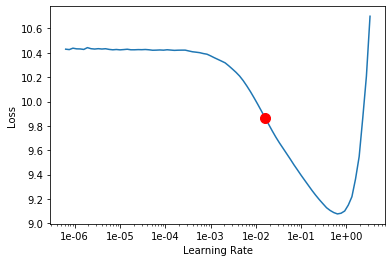

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [15]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.068420,5.868133,0.167586,03:28
1,5.695904,5.652025,0.183308,03:32


In [16]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.306088,5.450472,0.199499,03:57
1,5.192542,5.306155,0.213978,03:58
2,4.995543,5.238440,0.222640,03:57
3,4.783431,5.227170,0.226424,03:57
4,4.635411,5.243537,0.226336,03:57


In [17]:
learn.predict("How do", n_words=10)

'How do any something way " duniya ki sabse ummid property ki'

In [0]:
learn.save_encoder('ft_enc')

3.2 Task LM pretraining

In [19]:
learn = language_model_learner(data_lm_task, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')
learn.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (14000 items)
x: LMTextList
xxbos nen xxunk vist xxunk xxunk xxunk xxunk xxunk xxunk lost xxunk xxunk j a xxunk jen xxunk xxmaj asi xxunk xxunk xxunk m xxunk j life ...,xxbos xxunk xxmaj haan yaar neha xxunk xxunk kab karega woh post xxunk xxmaj usne na sach mein photoshoot karna chahiye phir woh post karega,xxbos @rahulgandhi television media congress ke liye nhi h . xxmaj ye toh aapko pata chal hi gya hoga . xxmaj achha hoga ki xxmaj congress ke,xxbos @amitshah @narendramodi xxmaj all xxmaj india me nrc lagu kare w xxmaj kashmir se dhara ko khatam kare ham xxmaj indian ko apse yahi umid hai,xxbos @nehr_who xxunk @anjanaomkashyap xxmaj pagal hai kya ? xxmaj they xxunk ’ t real issues xxmaj mandir is important xxmaj hindu khatre mei jo hai !
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (3000 items)
x: LMTextList
xxbos xxunk modi xxunk may samil honay par badhai xxunk har,xxbos xxunk @tajinderbagga xxunk xxunk @shehla_rashid @taj

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 7.59E-02


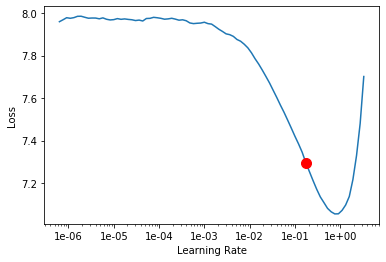

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [21]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.192169,5.988268,0.190520,00:13
1,5.406957,5.727890,0.206736,00:13


In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.521132,5.497923,0.222623,00:15
1,4.270754,5.549344,0.224291,00:15


In [23]:
learn.predict("modi ji", n_words=20)

'modi ji hame dhajjiya tiwari meri taraf se aap ko lr sakti ho apko bahut bahut subhkamnaye karya appki subhkamnaye .'

In [0]:
learn.save_encoder('ft_enc')

## 4. Using the Language Model to Train the Classifier

In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.to_fp16()
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14000 items)
x: TextList
xxbos nen xxunk vist xxunk xxunk xxunk xxunk xxunk xxunk lost xxunk xxunk j a xxunk jen xxunk xxmaj asi xxunk xxunk xxunk m xxunk j life ...,xxbos xxunk xxmaj haan yaar neha xxunk xxunk kab karega woh post xxunk xxmaj usne na sach mein photoshoot karna chahiye phir woh post karega,xxbos @rahulgandhi television media congress ke liye nhi h . xxmaj ye toh aapko pata chal hi gya hoga . xxmaj achha hoga ki xxmaj congress ke,xxbos @amitshah @narendramodi xxmaj all xxmaj india me nrc lagu kare w xxmaj kashmir se dhara ko khatam kare ham xxmaj indian ko apse yahi umid hai,xxbos @nehr_who xxunk @anjanaomkashyap xxmaj pagal hai kya ? xxmaj they xxunk ’ t real issues xxmaj mandir is important xxmaj hindu khatre mei jo hai !
y: CategoryList
neutral,neutral,negative,positive,neutral
Path: .;

Valid: LabelList (3000 items)
x: TextList
xxbos xxunk modi xxunk may samil honay par badhai xxunk har,xxbos xxunk @tajinderbagga 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 2.29E-03


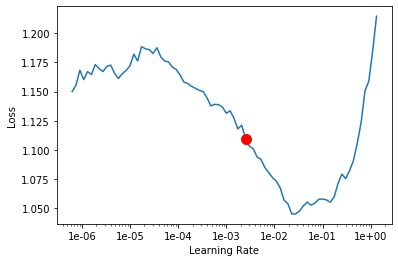

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [27]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.928537,0.890973,0.560000,00:06
1,0.897036,0.884705,0.560667,00:06


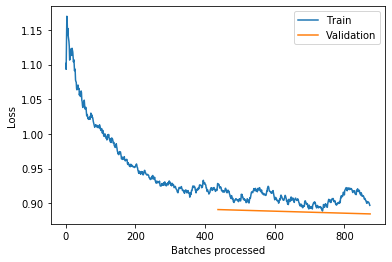

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.889056,0.897465,0.564667,00:07
1,0.893292,0.875179,0.572000,00:08
2,0.845467,0.860043,0.582333,00:07
3,0.820952,0.856143,0.584000,00:07


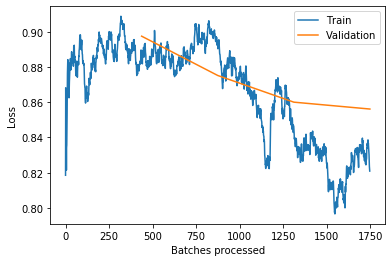

In [30]:
learn.recorder.plot_losses()

## 5. Analyzing our results

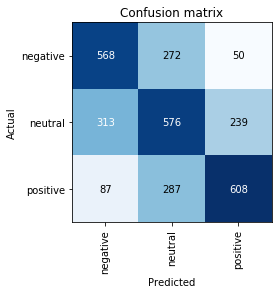

In [31]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [32]:
interp.most_confused()

[('neutral', 'negative', 313),
 ('positive', 'neutral', 287),
 ('negative', 'neutral', 272),
 ('neutral', 'positive', 239),
 ('positive', 'negative', 87),
 ('negative', 'positive', 50)]

## 6. Predictions

In [49]:
learn.predict("bhai Meri taraf se Best wishes di jye ga apnay bhai ko ")

(Category positive, tensor(2), tensor([0.0327, 0.2002, 0.7671]))

## 7. Export the model

In [0]:
save_path = "/content/SemEval_weights_data/models/classifier.pth"
learn.export(save_path)

In [165]:
df_trn.text.values

array(['nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...',
       '@nehantics Haan yaar neha pensive_face pensive_face kab karega woh post loudly_crying_face Usne na sach mein photoshoot karna chahiye phir woh post karega ',
       '@RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke ',
       '@AmitShah @narendramodi All India me nrc lagu kare w Kashmir se dhara ko khatam kare ham Indian ko apse yahi umid hai',
       ...,
       "so i couldn't get no one to cover me for my birthday / but im going to open that day so i mean i guess it's okkk",
       'RT @theskindoctor @NajimKhan Aap logo ki baat nahi kar raha Najim bhai Media walo ki kar raha hu jo bina janche parkhe one sided news ',
       '@PriyaVerma __ @ashutoshB Jay Jay Shree Ram ram rajye aaya he danavo rakshasho chudelno or surpankha ke gharoke sa ',
       '@kanpuriya_Mujhe to bhayankar ho gaya h

# Stacking

## Fastai predictions

In [191]:
fastai_preds_train = [[learn.predict([x])[1].tolist()] for x in df_trn.text]
fastai_preds_test = learn.get_preds()[1].numpy().reshape(-1,1)
fastai_preds_train[:10]

AttributeError: ignored

In [0]:
import os, re, time
from collections import Counter
from os.path import join as joinpath
# from tqdm import tqdm
# tqdm.pandas()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

pd.options.display.max_rows = 1000

## Classical 1 predictions

In [224]:
# vec = CountVectorizer(min_df=10, max_df=1., analyzer='word', ngram_range=(1, 1), stop_words='english') 
vec = TfidfVectorizer(min_df=10, max_df=1., analyzer='word', ngram_range=(1, 1), stop_words='english') 
X_train = vec.fit_transform(df_trn['text'].values)
X_test = vec.transform(df_val['text'].values)

y_train = df_trn['label'].values
y_test = df_val['label'].values

optimal_alpha = .1

# classifier = BernoulliNB(alpha=optimal_alpha)
# classifier = MultinomialNB(alpha=optimal_alpha) #59.4

# classifier = RandomForestClassifier(n_estimators=40, min_samples_split=2, random_state=0, n_jobs=4) #58
# classifier = SGDClassifier(max_iter=1000) #59.6
classifier = SVC(kernel='rbf', random_state=0) #60.7

# fitting the model
classifier.fit(X_train, y_train)

# predict the response
pred = classifier.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print(f'Accuracy: {acc}')

Accuracy: 60.6


In [226]:
# classical1_pred_train = classifier.predict_proba(X_train).argmax(axis=1).reshape(-1,1)
# classical1_pred_test = classifier.predict_proba(X_test).argmax(axis=1).reshape(-1,1)
# classical1_pred_train

classical1_pred_train = classifier.decision_function(X_train).argmax(axis=1).reshape(-1,1)
classical1_pred_test = classifier.decision_function(X_test).argmax(axis=1).reshape(-1,1)
classical1_pred_train

array([[1],
       [1],
       [1],
       [2],
       ...,
       [2],
       [1],
       [2],
       [1]])

## Classical 2 predictions

In [231]:
vec = CountVectorizer(min_df=10, max_df=1., analyzer='word', ngram_range=(1, 1), stop_words='english') 
# vec = TfidfVectorizer(min_df=1, max_df=1., analyzer='word', ngram_range=(1, 1), stop_words='english') 
X_train = vec.fit_transform(df_trn['text'].values)
X_test = vec.transform(df_val['text'].values)

y_train = df_trn['label'].values
y_test = df_val['label'].values

optimal_alpha = .1

# classifier = BernoulliNB(alpha=optimal_alpha)
# classifier = MultinomialNB(alpha=optimal_alpha) #59.4

classifier = RandomForestClassifier(n_estimators=40, min_samples_split=5, random_state=0, n_jobs=4) #58
# classifier = SGDClassifier(max_iter=1000) #59.6
# classifier = SVC(kernel='rbf', random_state=0) #60.7

# fitting the model
classifier.fit(X_train, y_train)

# predict the response
pred = classifier.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print(f'Accuracy: {acc}')

Accuracy: 59.233333333333334


In [232]:
classical2_pred_train = classifier.predict_proba(X_train).argmax(axis=1).reshape(-1,1)
classical2_pred_test = classifier.predict_proba(X_test).argmax(axis=1).reshape(-1,1)
classical2_pred_train

array([[1],
       [1],
       [1],
       [2],
       ...,
       [2],
       [2],
       [2],
       [1]])

## Stacked predictions

In [233]:
X_train = np.hstack([fastai_preds_train, classical1_pred_train, classical2_pred_train])
X_test = np.hstack([fastai_preds_test, classical1_pred_test, classical2_pred_test])
y_train = df_trn['label']
y_test = df_val['label']

X_train.shape, X_test.shape

((14000, 3), (3000, 3))

In [235]:
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, df_val['label'], test_size = 0.1, random_state=0)

optimal_alpha = .1

# classifier = BernoulliNB(alpha=optimal_alpha)
# classifier = MultinomialNB(alpha=optimal_alpha) #59.4

# classifier = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=0, n_jobs=4) #58
# classifier = SGDClassifier(max_iter=1000) #59.6
classifier = SVC(kernel='rbf', random_state=0) #60.7
# classifier = LogisticRegression(random_state=0, n_jobs=4)

# fitting the model
classifier.fit(X_train, y_train)

# predict the response
pred = classifier.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print(f'Accuracy: {acc}')

Accuracy: 59.233333333333334
